# StateGraph

In the previous section, we demonstrated how to create a ReAct Agent using LangGraph. However, delegating tasks to an Agent means giving away control. If you don't want the Agent to have such high control, but instead want the process to be entirely under your control, you can use **StateGraph** to create workflows.

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain.messages import HumanMessage, SystemMessage
from langchain.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableConfig

# Load model configuration
_ = load_dotenv()

This section implements a simple workflow. This workflow connects to a weather query tool. Unlike the ReAct Agent which can autonomously decide to call tools, here we manually write the tool trigger logic through "conditional edges".

To achieve this goal, we need to create three things:

- **Assistant Node**: Loaded with LLM, used to determine whether a tool needs to be called
- **Tool Node**: A tool for getting city weather. Here we simplify it to always output sunny for any city
- **Conditional Edge**: Connects the assistant node and tool node. Decides whether to call the tool based on the assistant node's output

In [2]:
# Load model
llm = ChatOpenAI(
    model="qwen3-coder-plus",
    temperature=0.7,
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url=os.getenv("DASHSCOPE_BASE_URL"),
)

# Tool function
@tool
def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

# Create tool node
tools = [get_weather]
tool_node = ToolNode(tools)

# Create assistant node
def assistant(state: MessagesState, config: RunnableConfig):
    system_prompt = 'You are a helpful assistant that can check weather.'
    all_messages = [SystemMessage(system_prompt)] + state['messages']
    model = llm.bind_tools(tools)
    return {'messages': [model.invoke(all_messages)]}

# Create conditional edge
def should_continue(state: MessagesState, config: RunnableConfig):
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'continue'
    return 'end'

With these three components, we have the basic ingredients to build a StateGraph. But to make the StateGraph run, we also need to **define the relationships between nodes and edges**. In the code below, we first add nodes to the StateGraph instance, then bridge them in the correct order. This gives us a runnable workflow.

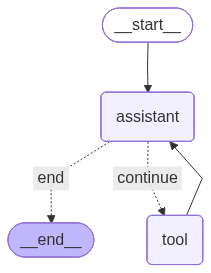

In [3]:
# Create graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node('assistant', assistant)
builder.add_node('tool', tool_node)

# Add edges
builder.add_edge(START, 'assistant')

# Add conditional edges
builder.add_conditional_edges(
    'assistant',
    should_continue,
    {
        'continue': 'tool',
        'end': END,
    },
)

# Add edge: return to assistant after calling tool node
builder.add_edge('tool', 'assistant')

# Compile graph
my_graph = builder.compile(name='my-graph')
my_graph

> **Note**
>
> Directed graphs are divided into:
>
> - Directed Acyclic Graph (DAG)
> - Directed Cyclic Graph (DCG)

From the visualization results, we can see that there is a cyclic call between the assistant node `assistant` and the tool node `tool`. Therefore, what we created is a **Directed Cyclic Graph**. Let's look at the workflow's running process when asking about Shanghai's weather.

In [4]:
# Invoke graph
response = my_graph.invoke({'messages': [HumanMessage(content='How is the weather in Shanghai?')]})
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

How is the weather in Shanghai?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_fc1bae01e9514b389c53781b)
 Call ID: call_fc1bae01e9514b389c53781b
  Args:
    city: Shanghai
================================= Tool Message =================================
Name: get_weather

It's always sunny in Shanghai!
================================== Ai Message ==================================

The current weather in Shanghai is sunny. If you need more detailed information or updates, feel free to ask!
